In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.9.1


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
# Define dirs and files
train_data_dir = '../data/images/train'
val_data_dir = '../data/images/val'

#set batch Size
batch_size = 32

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)



train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=imsize,
  batch_size = batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  image_size=imsize,
  batch_size = batch_size)


class_names = train_ds.class_names
print(class_names)


Found 3364 files belonging to 35 classes.
Found 535 files belonging to 35 classes.
['breakwater', 'bridge', 'canal', 'cliff', 'culvert', 'cypress_tree', 'dam', 'ditch', 'fjord', 'flood', 'glaciers', 'hot_spring', 'lake', 'levee', 'lighthouse', 'mangrove', 'marsh', 'offshore_platform', 'pier', 'pipeline', 'puddle', 'rapids', 'reservoir', 'river', 'river_delta', 'sea', 'ship', 'shoreline', 'snow', 'spillway', 'swimming_pool', 'water_tower', 'water_well', 'waterfall', 'wetland']


In [4]:
total_train = 3364
total_val = 535

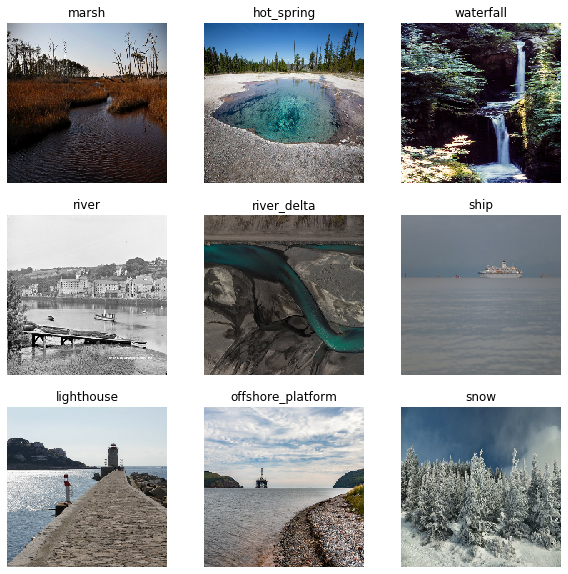

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [6]:
normalization_layer = layers.Rescaling(1./255)
flip_layer = layers.RandomFlip("horizontal_and_vertical")
zoom_layer = layers.RandomZoom(.5, .2)
rot_layer = layers.RandomRotation(factor=(-0.2, 0.3), fill_mode='reflect')


normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_train_ds = normalized_train_ds.map(lambda x, y: (flip_layer(x), y))
normalized_train_ds = normalized_train_ds.map(lambda x, y: (zoom_layer(x), y))
normalized_train_ds = normalized_train_ds.map(lambda x, y: (rot_layer(x), y))




normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

for image_batch, labels_batch in normalized_val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [7]:
auto = tf.data.AUTOTUNE

normalized_train_ds = normalized_train_ds.shuffle(buffer_size=100)
normalized_train_ds = normalized_train_ds.repeat()
normalized_train_ds = normalized_train_ds.prefetch(auto)

normalized_val_ds = normalized_val_ds.shuffle(buffer_size=100)
normalized_val_ds = normalized_val_ds.repeat()
normalized_val_ds = normalized_val_ds.prefetch(auto)

In [8]:
#load or build model
##########

#from scratch:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

# to freeze the batch Norm layers
base_model.training = False

#base model not trainable
base_model.trainable = False

#base_model.summary()

In [9]:
# add a new classifcation layer
final_layer = base_model.get_layer('out_relu')
#print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output

# add avg pool
x = layers.GlobalAveragePooling2D()(final_base_output)
#add a dense
#x = layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a final sigmoid layer for classification
x = layers.Dense(35, activation='softmax')(x)   

model = Model(base_model.input, x) 
#############
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [10]:
# define the metrics
acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='acc')

In [11]:
#build the model
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
              metrics = acc_metric)

/usr/lib/python3/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 20, 
                                             restore_best_weights = True)

In [13]:
#train the model
history = model.fit(normalized_train_ds,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = normalized_val_ds,
                    epochs= 200,
                    validation_steps =  total_val // batch_size,
                    workers = 24,
                    callbacks = [callbacks])

Epoch 1/200
105/105 [==============================] - 35s 167ms/step - loss: 3.6693 - acc: 0.0624 - val_loss: 3.5818 - val_acc: 0.0636
Epoch 2/200
105/105 [==============================] - 16s 155ms/step - loss: 3.3178 - acc: 0.1161 - val_loss: 3.3525 - val_acc: 0.1034
Epoch 3/200
105/105 [==============================] - 16s 155ms/step - loss: 3.1227 - acc: 0.1597 - val_loss: 3.1668 - val_acc: 0.1471
Epoch 4/200
105/105 [==============================] - 16s 155ms/step - loss: 2.9463 - acc: 0.1954 - val_loss: 3.0389 - val_acc: 0.1909
Epoch 5/200
105/105 [==============================] - 16s 155ms/step - loss: 2.8331 - acc: 0.2317 - val_loss: 2.9038 - val_acc: 0.2286
Epoch 6/200
105/105 [==============================] - 16s 156ms/step - loss: 2.7144 - acc: 0.2584 - val_loss: 2.7798 - val_acc: 0.2565
Epoch 7/200
105/105 [==============================] - 16s 154ms/step - loss: 2.6224 - acc: 0.2746 - val_loss: 2.6886 - val_acc: 0.2803
Epoch 8/200
105/105 [===========================

Epoch 61/200
105/105 [==============================] - 16s 155ms/step - loss: 1.6929 - acc: 0.5030 - val_loss: 1.8507 - val_acc: 0.4930
Epoch 62/200
105/105 [==============================] - 16s 154ms/step - loss: 1.7062 - acc: 0.4994 - val_loss: 1.8754 - val_acc: 0.4831
Epoch 63/200
105/105 [==============================] - 16s 154ms/step - loss: 1.7030 - acc: 0.4985 - val_loss: 1.8811 - val_acc: 0.4751
Epoch 64/200
105/105 [==============================] - 16s 156ms/step - loss: 1.7135 - acc: 0.5024 - val_loss: 1.8603 - val_acc: 0.4712
Epoch 65/200
105/105 [==============================] - 16s 154ms/step - loss: 1.7149 - acc: 0.4918 - val_loss: 1.8551 - val_acc: 0.4891
Epoch 66/200
105/105 [==============================] - 16s 154ms/step - loss: 1.6685 - acc: 0.5170 - val_loss: 1.8548 - val_acc: 0.4712
Epoch 67/200
105/105 [==============================] - 16s 154ms/step - loss: 1.7064 - acc: 0.5063 - val_loss: 1.8691 - val_acc: 0.4652
Epoch 68/200
105/105 [===================

105/105 [==============================] - 16s 154ms/step - loss: 1.5048 - acc: 0.5546 - val_loss: 1.8368 - val_acc: 0.4911
Epoch 121/200
105/105 [==============================] - 16s 154ms/step - loss: 1.4866 - acc: 0.5558 - val_loss: 1.8226 - val_acc: 0.4941
Epoch 122/200
105/105 [==============================] - 16s 154ms/step - loss: 1.4529 - acc: 0.5798 - val_loss: 1.8152 - val_acc: 0.4990
Epoch 123/200
105/105 [==============================] - 16s 155ms/step - loss: 1.4817 - acc: 0.5708 - val_loss: 1.8495 - val_acc: 0.4811
Epoch 124/200
105/105 [==============================] - 16s 154ms/step - loss: 1.5035 - acc: 0.5591 - val_loss: 1.8325 - val_acc: 0.4791
Epoch 125/200
105/105 [==============================] - 16s 154ms/step - loss: 1.4577 - acc: 0.5640 - val_loss: 1.8396 - val_acc: 0.4791
Epoch 126/200
105/105 [==============================] - 16s 154ms/step - loss: 1.4951 - acc: 0.5587 - val_loss: 1.8183 - val_acc: 0.5050


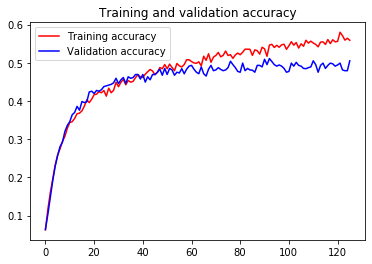

<Figure size 432x288 with 0 Axes>

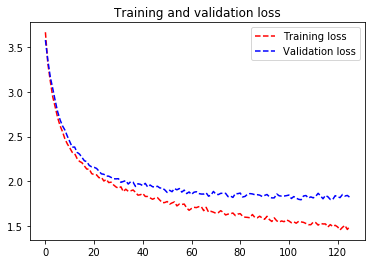

<Figure size 432x288 with 0 Axes>

In [14]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [15]:
ImPath = "../data/images/test/hot_spring/27853467597.jpg" #hotspring index 11 test
#ImPath = "../data/images/test/breakwater/30326724408.jpg" #breakwater index 0 test
#ImPath = "../data/images/test/wetland/49217387201.jpg" #wetland index 34 test
TestIm = tf.keras.preprocessing.image.load_img(ImPath,target_size = (224,224))
TestIm = tf.keras.preprocessing.image.img_to_array(TestIm)
TestIm = (TestIm/255)
TestIm = np.expand_dims(TestIm,axis=0)

pred = model.predict(TestIm)
print(pred)
np.argmax(pred)

1/1 [==============================] - 1s 738ms/step
[[1.76091341e-03 5.57709536e-05 2.18556670e-04 1.02458952e-03
  7.39421666e-05 1.03778875e-05 3.37932113e-04 7.53938570e-04
  3.11942049e-03 5.10723796e-04 1.57513504e-03 9.70080912e-01
  2.15178216e-03 2.68231845e-04 9.72713227e-04 1.29579625e-04
  1.70777144e-04 2.51584075e-04 2.83921137e-04 3.60196937e-05
  3.96121846e-04 7.02551333e-04 9.31795454e-04 7.61988526e-03
  1.40171578e-05 1.18735794e-03 8.63801542e-05 1.25410536e-03
  5.13162697e-04 8.29941302e-04 9.02187548e-06 8.04220545e-05
  8.39332006e-06 2.39293114e-03 1.86944104e-04]]


11

In [16]:
# #save the model
#filepath = './Aquanet_class_noFT'
# model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

In [17]:
# #Full model finetune (even though the batch norm layers are frowzen from Training = False)
# base_model.trainable = True

# #build the model
# model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
#               optimizer = tf.keras.optimizers.Adam(lr = 1e-5),
#               metrics = acc_metric)

# #train the model
# history = model.fit(normalized_train_ds,
#                     steps_per_epoch = total_train // batch_size,
#                     validation_data = normalized_val_ds,
#                     epochs= 200,
#                     validation_steps =  total_val // batch_size,
#                     workers = 24,
#                     callbacks = [callbacks])


In [18]:
# #look at the metrics from 2nd finetune step
# %matplotlib inline
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# plt.plot(epochs, loss, 'r--', label='Training loss')
# plt.plot(epochs, val_loss, 'b--', label='Validation loss')
# plt.title('Training and validation loss') 
# plt.legend(loc=0)
# plt.figure()
# plt.show()


In [19]:
#save the model
filepath = './Atlantis_TFdata'
model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

INFO:tensorflow:Assets written to: ./Atlantis_TFdata/assets


INFO:tensorflow:Assets written to: ./Atlantis_TFdata/assets


In [20]:
# filepath = './Atlantis_TFdata'
# model = tf.keras.models.load_model(filepath, compile = True)

# # Convert the keras model using TFLiteConverter.
# # Keras model converter API uses the default signature automatically.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Print the signatures from the converted model
# interpreter = tf.lite.Interpreter(model_content=tflite_model)

# signatures = interpreter.get_signature_list()
# print(signatures)


In [21]:
# #quantize
# filepath = './Atlantis_TFdata'
# model = tf.keras.models.load_model(filepath, compile = True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]


#make rep dataste
rep_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=imsize,
  batch_size = 1)

normalized_rep_ds = rep_ds.map(lambda x, y: (normalization_layer(x), y))



def representative_dataset():
    for data, _ in normalized_rep_ds.take(1000):
        #print(tf.dtypes.cast(data, tf.float32).shape)
        yield [tf.dtypes.cast(data, tf.float32)]
    
converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()


with open('ATLANTIS_cat_OMV.tflite','wb') as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

Found 3364 files belonging to 35 classes.


INFO:tensorflow:Assets written to: /tmp/tmp9mz_2y2g/assets


INFO:tensorflow:Assets written to: /tmp/tmp9mz_2y2g/assets
/usr/lib/python3/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [22]:
interpreter.get_output_details()[0]

{'name': 'StatefulPartitionedCall:0',
 'index': 177,
 'shape': array([ 1, 35], dtype=int32),
 'shape_signature': array([-1, 35], dtype=int32),
 'dtype': numpy.int8,
 'quantization': (0.00390625, -128),
 'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
  'zero_points': array([-128], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}